# Imports

In [1]:
#Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm



from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [4]:
import numpy as np
import pandas as pd
import os

file_list = ['DeepCNNSiLU_9L_IxG.npy', 'DeepCNNSiLU_9L_IG.npy', 'DeepCNNSiLU_9L_Saliency.npy', 'DeepCNNSiLU_9L_LayerGradCam.npy']

data = {}
for file_name in file_list:
    
    arr = np.load(file_name)
    
    column_name = os.path.splitext(file_name)[0]
    data[column_name] = arr
    
df = pd.DataFrame(data)
df

,DeepCNNSiLU_9L_IxG,DeepCNNSiLU_9L_IG,DeepCNNSiLU_9L_Saliency,DeepCNNSiLU_9L_LayerGradCam
0,-4.368711e-01,-1.038035e+00,20.977081,-3.147532e-03
1,8.657585e+00,7.243870e+00,26.567974,-5.571545e-03
2,7.244169e+00,6.937872e+00,23.035192,-1.455660e-03
3,6.185846e-02,-4.965377e-01,19.307569,3.068978e-04
4,-4.177575e-05,-2.062058e-05,17.888805,-6.346466e-04
...,...,...,...,...
1945,5.284818e-08,9.426865e-09,0.004797,8.217006e-08
1946,2.049477e-08,3.946664e-09,0.004797,8.216477e-08
1947,2.602889e-10,3.673547e-11,0.004797,8.216104e-08
1948,1.291463e-09,1.917716e-10,0.004797,5.754021e-08


In [5]:
p_deviation = pd.DataFrame() 

for column in df.columns:
    if column == 'feature':
        
        continue
    
    mean = df[column].mean()
    p_deviation[f'{column}_p_deviation'] = (((df[column] - mean) / mean) * 100) # считаем процентное среднее
    
p_deviation['mean_deviation'] = p_deviation.mean(axis=1)

features_range = p_deviation.sort_values(by='mean_deviation', ascending=False)
features_range

,DeepCNNSiLU_9L_IxG_p_deviation,DeepCNNSiLU_9L_IG_p_deviation,DeepCNNSiLU_9L_Saliency_p_deviation,DeepCNNSiLU_9L_LayerGradCam_p_deviation,mean_deviation
1,108630.418451,111589.502189,38129.820318,89029.744400,86844.871340
2,90879.359834,106871.477130,33046.346250,23186.649679,63495.958223
0,-5586.654026,-16104.926244,30084.839963,50252.049814,14661.327377
5,-100.416358,-100.089719,19457.035362,17150.031932,9101.640304
4,-100.524661,-100.317938,25640.985372,10052.639619,8873.195598
...,...,...,...,...,...
1104,-100.000000,-100.000000,-93.098092,-101.314432,-98.603131
649,-100.000000,-100.000000,-93.098092,-101.314432,-98.603131
186,-99.999999,-100.000000,-93.098093,-101.314433,-98.603131
1257,-99.999999,-100.000000,-93.098092,-101.314434,-98.603131


In [6]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [7]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 53.3 s, sys: 5.05 s, total: 58.4 s
Wall time: 57.9 s


In [8]:
from tqdm import tqdm
import sys
import time

# Data selection 

In [9]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)



In [10]:
width = 100

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 51070.78it/s]


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)
  
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))
  
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

['1_chr1' '1_chr1' '1_chr1' ... '0_chr18' '0_chr8' '0_chr6']


In [10]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# All models

In [12]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output

In [13]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepCNNSiLU_9L(nn.Module):
    def __init__(self, top_count):
        super().__init__()
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 9, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([9, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(9, 9, kernel_size=(5, 5), padding=2),
            nn.SiLU(),
            
            nn.Conv2d(9, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 3, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([1, 100, top_count]),  # Укажите размеры после свертки
            nn.SiLU(),
            
            nn.Linear(top_count, 500),
            nn.SiLU(),
            
            nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, top_count)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

# Train and test

In [14]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer, loader_train):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in tqdm(loader_train, desc='Train') :
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        
        output = model(X_batch)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model, loader_test):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in tqdm(loader_test, desc='Test'):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        
        f1_log.append(f1)
        
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        if output.dim() == 2:  
            output = output.unsqueeze(0)
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, loader_train, loader_test):
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt, loader_train)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model, loader_test)
        
        end_time = time.time()
        t = end_time - start_time
        times.append(t)
        
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
#         raise BaseException
        clear_output()
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss), n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss), n_epochs)
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss), n_epochs)
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss), n_epochs)
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss), n_epochs)
        print("Time: ", t/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
            
           
    print("Final ROC-AUC = {:.4}".format(val_auc_log[-1]))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))
    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times    

# Запуск 700

In [20]:
top_count = 704  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

100%|█████████████████████████████████████████████████████████████████████████████████| 700/700 [00:20<00:00, 34.94it/s]


In [21]:
len(feature_names)

700

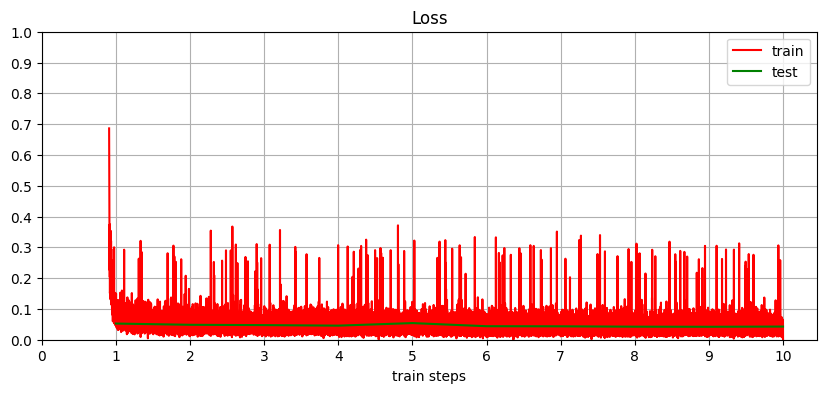

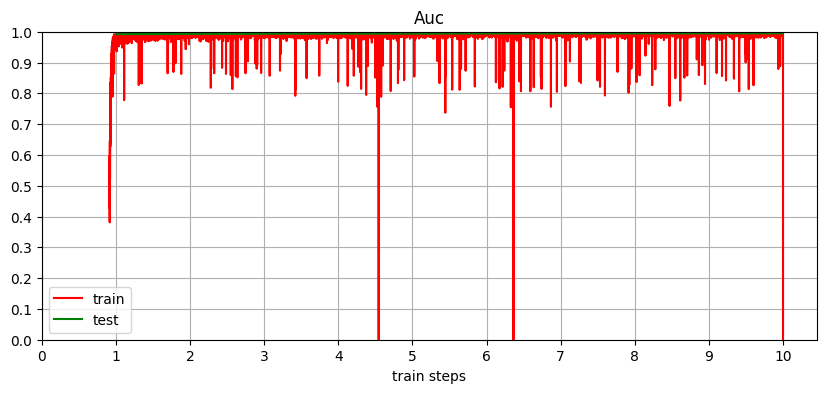

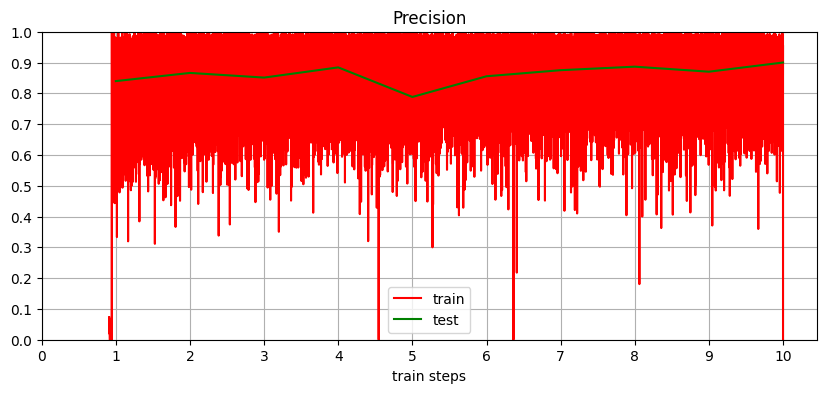

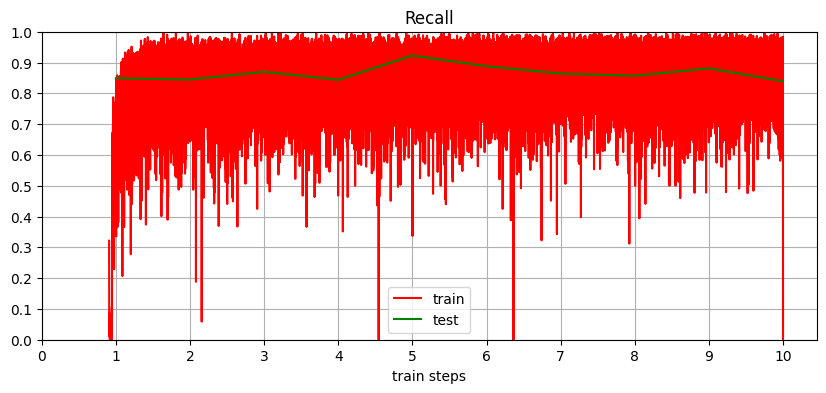

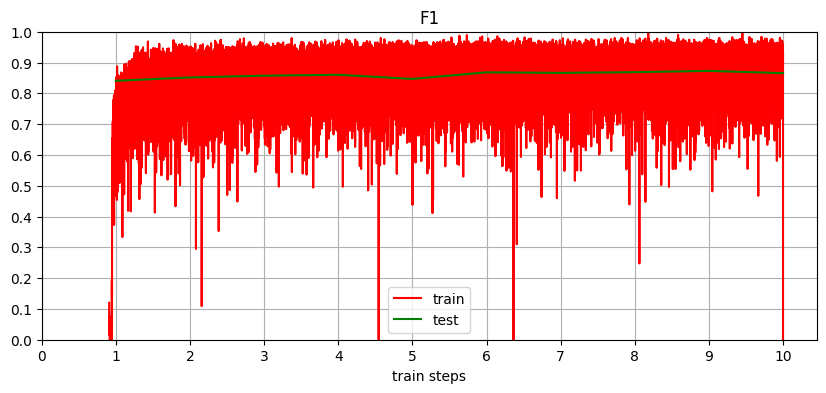

Time:  16.721775778134663
Epoch 10: ROC-AUC = 99.49%
Epoch 10: Precision = 0.9
Epoch 10: Recall = 0.839
Epoch 10: F1-score = 0.866
Final ROC-AUC = 0.9949
Final Precision = 0.9
Final Recall = 0.839
Final F1-score = 0.866
CPU times: user 2h 8min 28s, sys: 38min 50s, total: 2h 47min 19s
Wall time: 2h 47min 23s


In [22]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [23]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 9
Max F1-score: 0.8729
ROC-AUC: 0.9947
Precision: 0.8702
Recall: 0.8810
Mean time for 1 epoch 16.72 minutes


# 500

In [15]:
top_count = 504  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.39it/s]


In [16]:
len(feature_names)

500

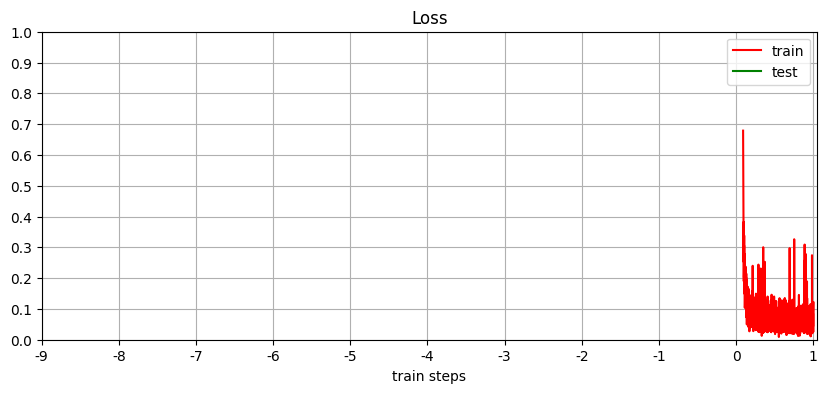

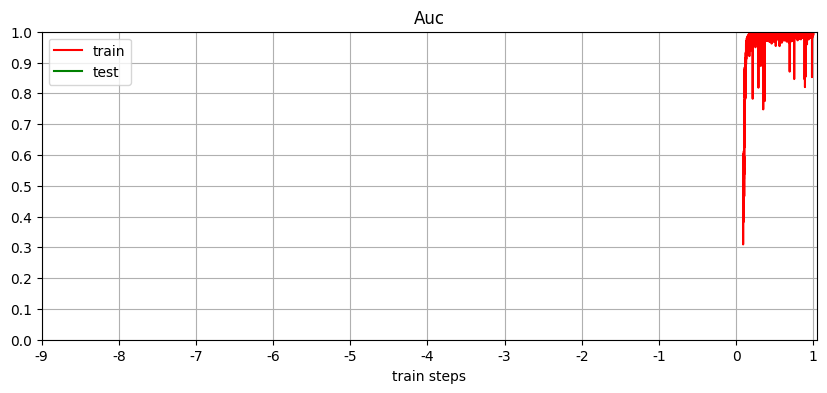

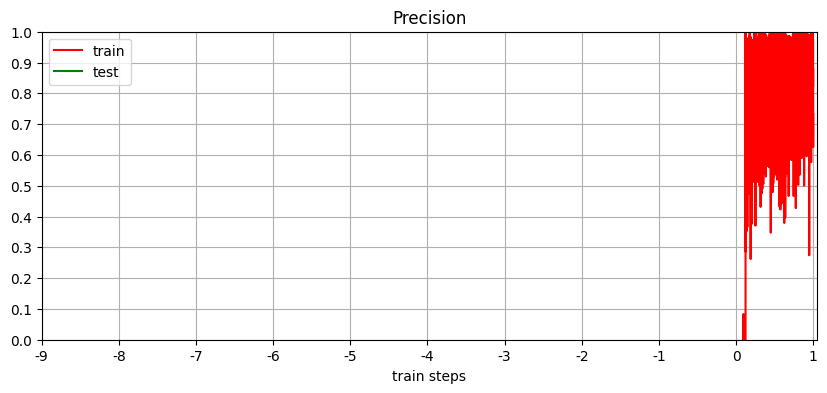

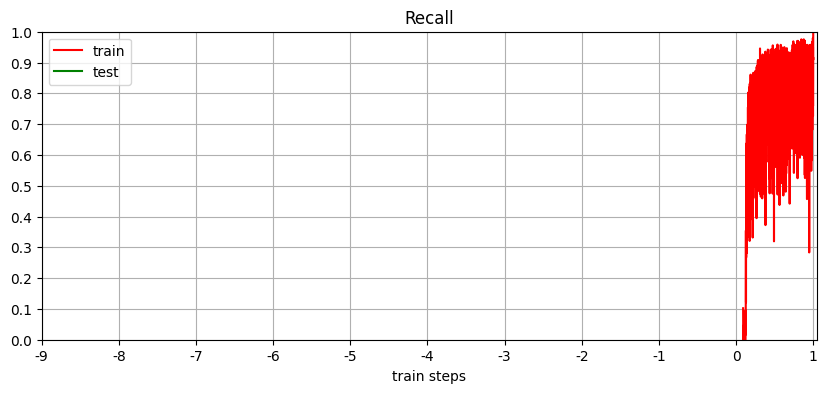

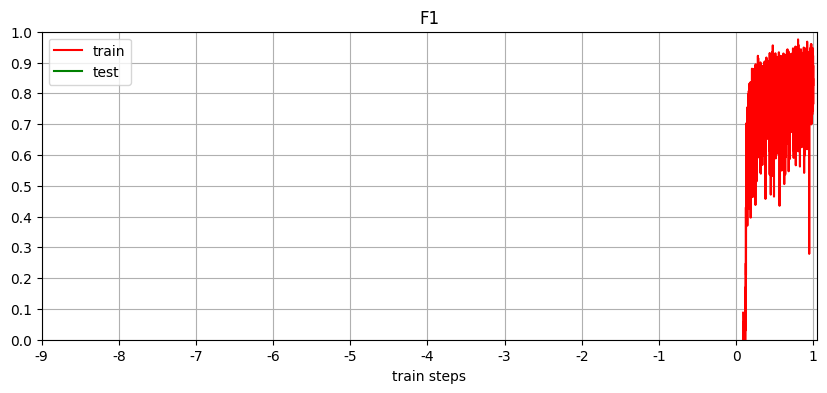

Time:  10.037897062301635
Epoch 1: ROC-AUC = 99.19%
Epoch 1: Precision = 0.853
Epoch 1: Recall = 0.831
Epoch 1: F1-score = 0.838
Epoch 2 of 10


Train:  62%|████████████████████████████████████████████▎                           | 2086/3391 [05:39<03:26,  6.32it/s]

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

# 300

In [ ]:
top_count = 304  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [ ]:
len(feature_names)

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

# 150

In [ ]:
top_count = 154  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [ ]:
len(feature_names)

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

# 100

In [ ]:
top_count = 104  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [ ]:
len(feature_names)

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

# 50

In [ ]:
top_count = 54  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [ ]:
len(feature_names)

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

# 0

In [ ]:
top_count = 4  # TODO вставить эту ячейку в свой код cnn

features_top = features_range.iloc[:top_count].index.tolist()
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]

top = []
for index in features_top:
    if index in [0, 1, 2, 3]:
        continue
        
    index = index - 4
    top.append(features[index])

features = top
feature_names = features

DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [ ]:
len(feature_names)

In [ ]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(top_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))